In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as spr
from scipy.sparse.linalg import inv

# Parameters

In [2]:
intSave=100
year = 3600*24*365

xi = 0.2
rhoi = 920
rhow = 1000
g = 9.81
mu_w = 1e-3
S = 1e-6

perm=1e-15
K_t = perm*rhow*g/mu_w
D = K_t/S

h_init = 1e3
dh=100

# Grids and pre-allocation

In [3]:
L = 40e3
nx = int(1e3+1)
x = np.linspace(0,L,num=nx)
dx = x[1]-x[0]

C_D = 1
dt = (dx**2)*C_D/D
tf = year*100
nt = int(np.round(tf/dt) + 1)
t = np.linspace(0,tf,num=nt)

h = h_init*(rhoi/rhow)*np.ones(nx)
h_all = np.zeros([nx,int(nt/intSave)+1])
h_all[:,0] = h

# Specify time-dependent load change

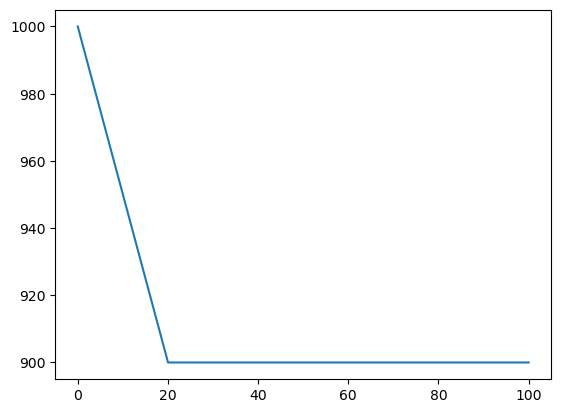

In [4]:
ramp_time = 20 #in years
hbc_sfc  = np.zeros(int(nt));
dhdt = np.zeros_like(hbc_sfc)
bramp_bool = t < ramp_time*year
aramp_bool = t >= ramp_time*year
hbc_sfc[bramp_bool] = np.linspace(h_init,h_init-dh,np.count_nonzero(bramp_bool, axis=None))
hbc_sfc[aramp_bool] = h_init-dh;
dhdt[1:] = np.diff(hbc_sfc)/dt

#dhdt[bramp_bool] = -np.linspace(0,2*dh/ramp_time,np.count_nonzero(bramp_bool, axis=None))/year
#hbc_sfc = h_init + np.cumsum(dhdt*dt)
plt.plot(t/year,hbc_sfc)

# Solve with Crank-Nicolson method

In [5]:
Mld = np.zeros([3,nx])
Mld[0,:] = -0.5*C_D*np.ones(nx)
Mld[2,:] = -0.5*C_D*np.ones(nx)
Mld[1,:] = (1+C_D)*np.ones(nx)
Ml = spr.spdiags(Mld,[-1,0,1],nx,nx);
Ml = spr.csc_matrix(Ml)
Ml[-1,-1] = 1+0.5*C_D
Ml[0,1] = 0
Ml[0,0] = 1
iMl = inv(Ml)

Mrd = np.zeros([3,nx])
Mrd[0,:] = 0.5*C_D*np.ones(nx)
Mrd[2,:] = 0.5*C_D*np.ones(nx)
Mrd[1,:] = (1-C_D)*np.ones(nx)
Mr = spr.spdiags(Mrd,[-1,0,1],nx,nx);
Mr = spr.csc_matrix(Mr)
Mr[-1,-1] = 1-0.5*C_D
Mr[0,1] = 0
Mr[0,0] = 1

/Users/arobel3/anaconda3/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [6]:
for k in np.arange(nt-1):
    hm = h
    hm.shape = (nx,1)
    h[0] = hbc_sfc[k]*(rhoi/rhow)
    
    Svec = np.zeros([nx,1])
    Svec[1:-2] = dt*xi*(rhoi/rhow)*dhdt[k]

    hnew = iMl.dot(Mr.dot(hm) + Svec)
    
    if k%intSave == 0:
        h_all[:,int(k/intSave)] = np.transpose(hnew)
    h = hnew

# Plot numerical against analytical solution

In [7]:
sfc_flux = np.transpose(K_t*(h_all[0,:]-h_all[1,:])/dx)

sflux_an = 2*(1-xi)*(rhoi/rhow)*dhdt[1]*(K_t*S*t/np.pi)**0.5
sflux_an_delta = (1-xi)*(rhoi/rhow)*dh*(K_t*S/(np.pi*t))**0.5;

tsub = t[0:-1:intSave]
t_bramp = t < ramp_time*year

/var/folders/98/bv9gl3vn43936p1jw639gxbc00xmln/T/ipykernel_84637/1918909175.py:4: RuntimeWarning: divide by zero encountered in divide
  sflux_an_delta = (1-xi)*(rhoi/rhow)*dh*(K_t*S/(np.pi*t))**0.5;


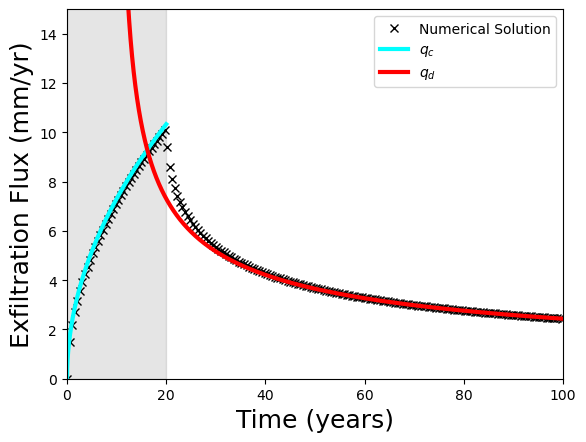

In [9]:
plt.plot(tsub/year,-1000*sfc_flux*year, 'x', color='black', linewidth=3, label = "Numerical Solution")
plt.plot(t[t_bramp]/year,-1000*sflux_an[t_bramp]*year, '-', color='cyan', linewidth=3,label = "$q_c$")
plt.plot(t[1:]/year + ramp_time/2,1000*sflux_an_delta[1:]*year, '-', color='red', linewidth=3,label = "$q_d$")
plt.fill_betweenx([0,16],0,20,color='k',alpha=0.1)
plt.xlabel('Time (a)',fontsize=18)
plt.ylabel('Exfiltration Flux (mm/a)',fontsize=18)
plt.legend()
plt.ylim(0,15)
plt.xlim(0,100)
#legend('Numerical','Analytic Constant','Analytic Delta','Location','NorthEast')
plt.savefig('Exfil_NumericalDiff_TimeDepLoad_1panel_v4.pdf', bbox_inches='tight', format='pdf')